In [15]:
import logging
import os
import sys
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold

from bootstrapping import bootstrapping

# from torch.utils.tensorboard import SummaryWriter
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import math
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset, Dataset, CacheDataset
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    DivisiblePadd,
    Flipd,
    ThresholdIntensityd,
    NormalizeIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    SpatialPadd,
    Compose,
    Rotate90d,
    RandRotate90,
    Resized,
    ScaleIntensity,
    Transposed,
    AsDiscrete,
    Activations,
    Transpose,
    RandRotate90d,
    RandGaussianNoised,
    Rand3DElasticd, 
    RandRotated,
    RandAffined,
    Zoomd,
    Identityd
)
from evaluate_thresholds import EvaluateThresholds
from monai.transforms import Transform
import torch

# let's try https://timm.fast.ai/models to see if it works with 3D images

# save prints in a txt file
# sys.stdout=open("/home/ubuntu/tenerife/data/ICH_results/Pretrained_image_model/DataAugmentationModels/run_out_"+str(model_name)+"_SmallDataAug_10fold.txt",'w')

pin_memory = torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

image_shape=512

# Set data directory
directory = "/home/ubuntu/tenerife/data/ICH_nii"
# read images and corresponding labels from directory
goodPrognosis_images = sorted(os.listdir(os.path.join(directory, "GOOD_PROGNOSIS")))
print(f"Good prognosis images(0): {len(goodPrognosis_images)}")
PoorPrognosis_images = sorted(os.listdir(os.path.join(directory, "POOR_PROGNOSIS")))
print(f"Poor prognosis images (1): {len(PoorPrognosis_images)}")

# read CLINICAL DATA
clinical_data = pd.read_csv('/home/ubuntu/tenerife/data/ICH_tabular_data/CLINICAL_DATA_ICH.csv', delimiter=',')
clinical_data = clinical_data.rename(columns={'PatientID': 'Patient'})
# drop row where Patient is 213
clinical_data_filtered = clinical_data[~clinical_data['Patient'].isin([213])]
clinical_data_filtered = clinical_data_filtered.reset_index(drop=True)

# reshape the input tensor to merge the depth dimension into the channel dimension to fit in timm model 
def reshape_input(x):
    batch_size, channels, depth, height, width = x.size()
    x = x.view(batch_size, channels * depth, height, width)
    return x

images_all=[]
labels_all=[]
# loop over Patient in clinical_data
for i in range(len(clinical_data)):
    # get patient ID
    patientID = clinical_data['Patient'][i]
    # get label
    label = clinical_data['Label (poor_prognosis)'][i]
    # read corresponding image
    if label==0:
        # check that image exists
        if os.path.isfile(os.path.join(directory, "GOOD_PROGNOSIS", str(patientID) + ".nii.gz")):
            images_all.append(os.path.join(directory, "GOOD_PROGNOSIS", str(patientID) + ".nii.gz"))
            labels_all.append(label)
    elif label==1:
        # check that image exists
        if os.path.isfile(os.path.join(directory, "POOR_PROGNOSIS", str(patientID) + ".nii.gz")):
            images_all.append(os.path.join(directory, "POOR_PROGNOSIS", str(patientID) + ".nii.gz"))
            labels_all.append(label)
    else:
        print("ERROR: for Patient", patientID, "label not found")
print("Number of images:", len(images_all))
print("Number of labels:", len(labels_all))
images_all=np.array(images_all)
labels_all=np.array(labels_all)

# create 5 fold cross validation

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
print("=" * 80)

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(skf.split(images_all, labels_all)):
    print(f"Fold {fold + 1}:")

    # Split the data into train and test sets
    images_train, images_test = images_all[train_index], images_all[test_index]
    labels_train, labels_test = labels_all[train_index], labels_all[test_index]

    # Further split the training set into train and validation sets
    images_train, images_val, labels_train, labels_val = train_test_split(
        images_train, labels_train, test_size=0.1, random_state=1, stratify=labels_train
    )

    # convert back to list
    images_train = images_train.tolist()
    images_val = images_val.tolist()
    images_test = images_test.tolist()
    labels_train = labels_train.tolist()
    labels_val = labels_val.tolist()
    labels_test = labels_test.tolist()

    # Print information for each fold
    print("Training set:", len(images_train), "images,", labels_train.count(0), "good prognosis,", labels_train.count(1), "poor prognosis")
    print("Validation set:", len(images_val), "images,", labels_val.count(0), "good prognosis,", labels_val.count(1), "poor prognosis")
    print("Test set:", len(images_test), "images,", labels_test.count(0), "good prognosis,", labels_test.count(1), "poor prognosis")
    print("=" * 80)

    # Count the occurrences of each class in the training set
    class_counts = {0: labels_train.count(0), 1: labels_train.count(1)}

    # Determine the target count for balancing
    target_count = max(class_counts.values())

    # Perform random oversampling on the minority class (class 1) ### TODO the oversampling technique could be improved
    ros = RandomOverSampler(sampling_strategy={0: target_count, 1: target_count}, random_state=2)
    images_res, labels_res = ros.fit_resample(np.array(images_train).reshape(-1, 1), np.array(labels_train).reshape(-1, 1))
    labels_res = labels_res.tolist()
    images_res = [item for sublist in images_res for item in sublist]
    print("Training set after resampling:", len(images_res), "images,", labels_res.count(0), "good prognosis,", labels_res.count(1), "poor prognosis")

    train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images_res, labels_res)]
    val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images_val, labels_val)]
    test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images_test, labels_test)]

    # https://github.com/Project-MONAI/tutorials/blob/main/modules/load_medical_images.ipynb

    # Define transforms
    train_transforms = Compose(
        [LoadImaged(keys="image", image_only=True, ensure_channel_first=True, reader="ITKReader"),
        Rotate90d(keys="image", k=3), 
        Flipd(keys="image", spatial_axis=1),
        NormalizeIntensityd(keys="image", subtrahend=15, divisor=85),
        ThresholdIntensityd(keys="image", threshold=0, above=True, cval=0.0),
        ThresholdIntensityd(keys="image", threshold=1, above=False, cval=0.0),
        Resized(keys="image", spatial_size=[image_shape, image_shape, -1]),
        SpatialPadd(keys="image", spatial_size=[-1, -1, 54], mode=('constant'), method= ("symmetric")),
        # RandRotated(keys="image", prob=1, range_z=np.pi/36, range_y=np.pi/36, range_z=np.pi/36), # randzoom, rand3delastic could also be used
        # RandAffined(keys="image", scale_range=(1, 1.1), rotate_range=(np.pi/36, np.pi/36), prob=1),
        # Zoomd(keys="image", zoom=1.1, prob=1),
        # Rand3DElasticd(keys="image", sigma_range=(2, 3), magnitude_range=(100, 200), prob=1),
        RandGaussianNoised(keys="image", prob=1, mean=0.0, std=0.01),
        Transposed(keys="image", indices=[0, 3, 1, 2])
        ])

    # Define nifti dataset, data loader
    check_ds = Dataset(data=train_files, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    try:
        result = monai.utils.misc.first(check_loader)
        print(type(result['image']), result['image'].shape, result['label'])
    except RuntimeError as e:
        print("Error occurred when applying transform:", e)
    # create a training data loader
    # train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
    train_ds = Dataset(data=train_files, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=24, shuffle=False, num_workers=2, pin_memory=pin_memory)
    break

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/tenerife/mambaforge/envs/testpy3/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.7
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED

/home/ubuntu/tenerife/mambaforge/envs/testpy3/lib/python3.8/site-packages/monai/transforms/io/array.py:205: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 1, 54, 512, 512]) tensor([1])


In [14]:
batch_data = next(iter(train_loader))  # Get one batch from the loader
images = batch_data['image']

images.shape

torch.Size([24, 1, 54, 512, 512])

In [18]:
images[0].shape

torch.Size([1, 54, 512, 512])

In [19]:
images[0][0].shape

torch.Size([54, 512, 512])

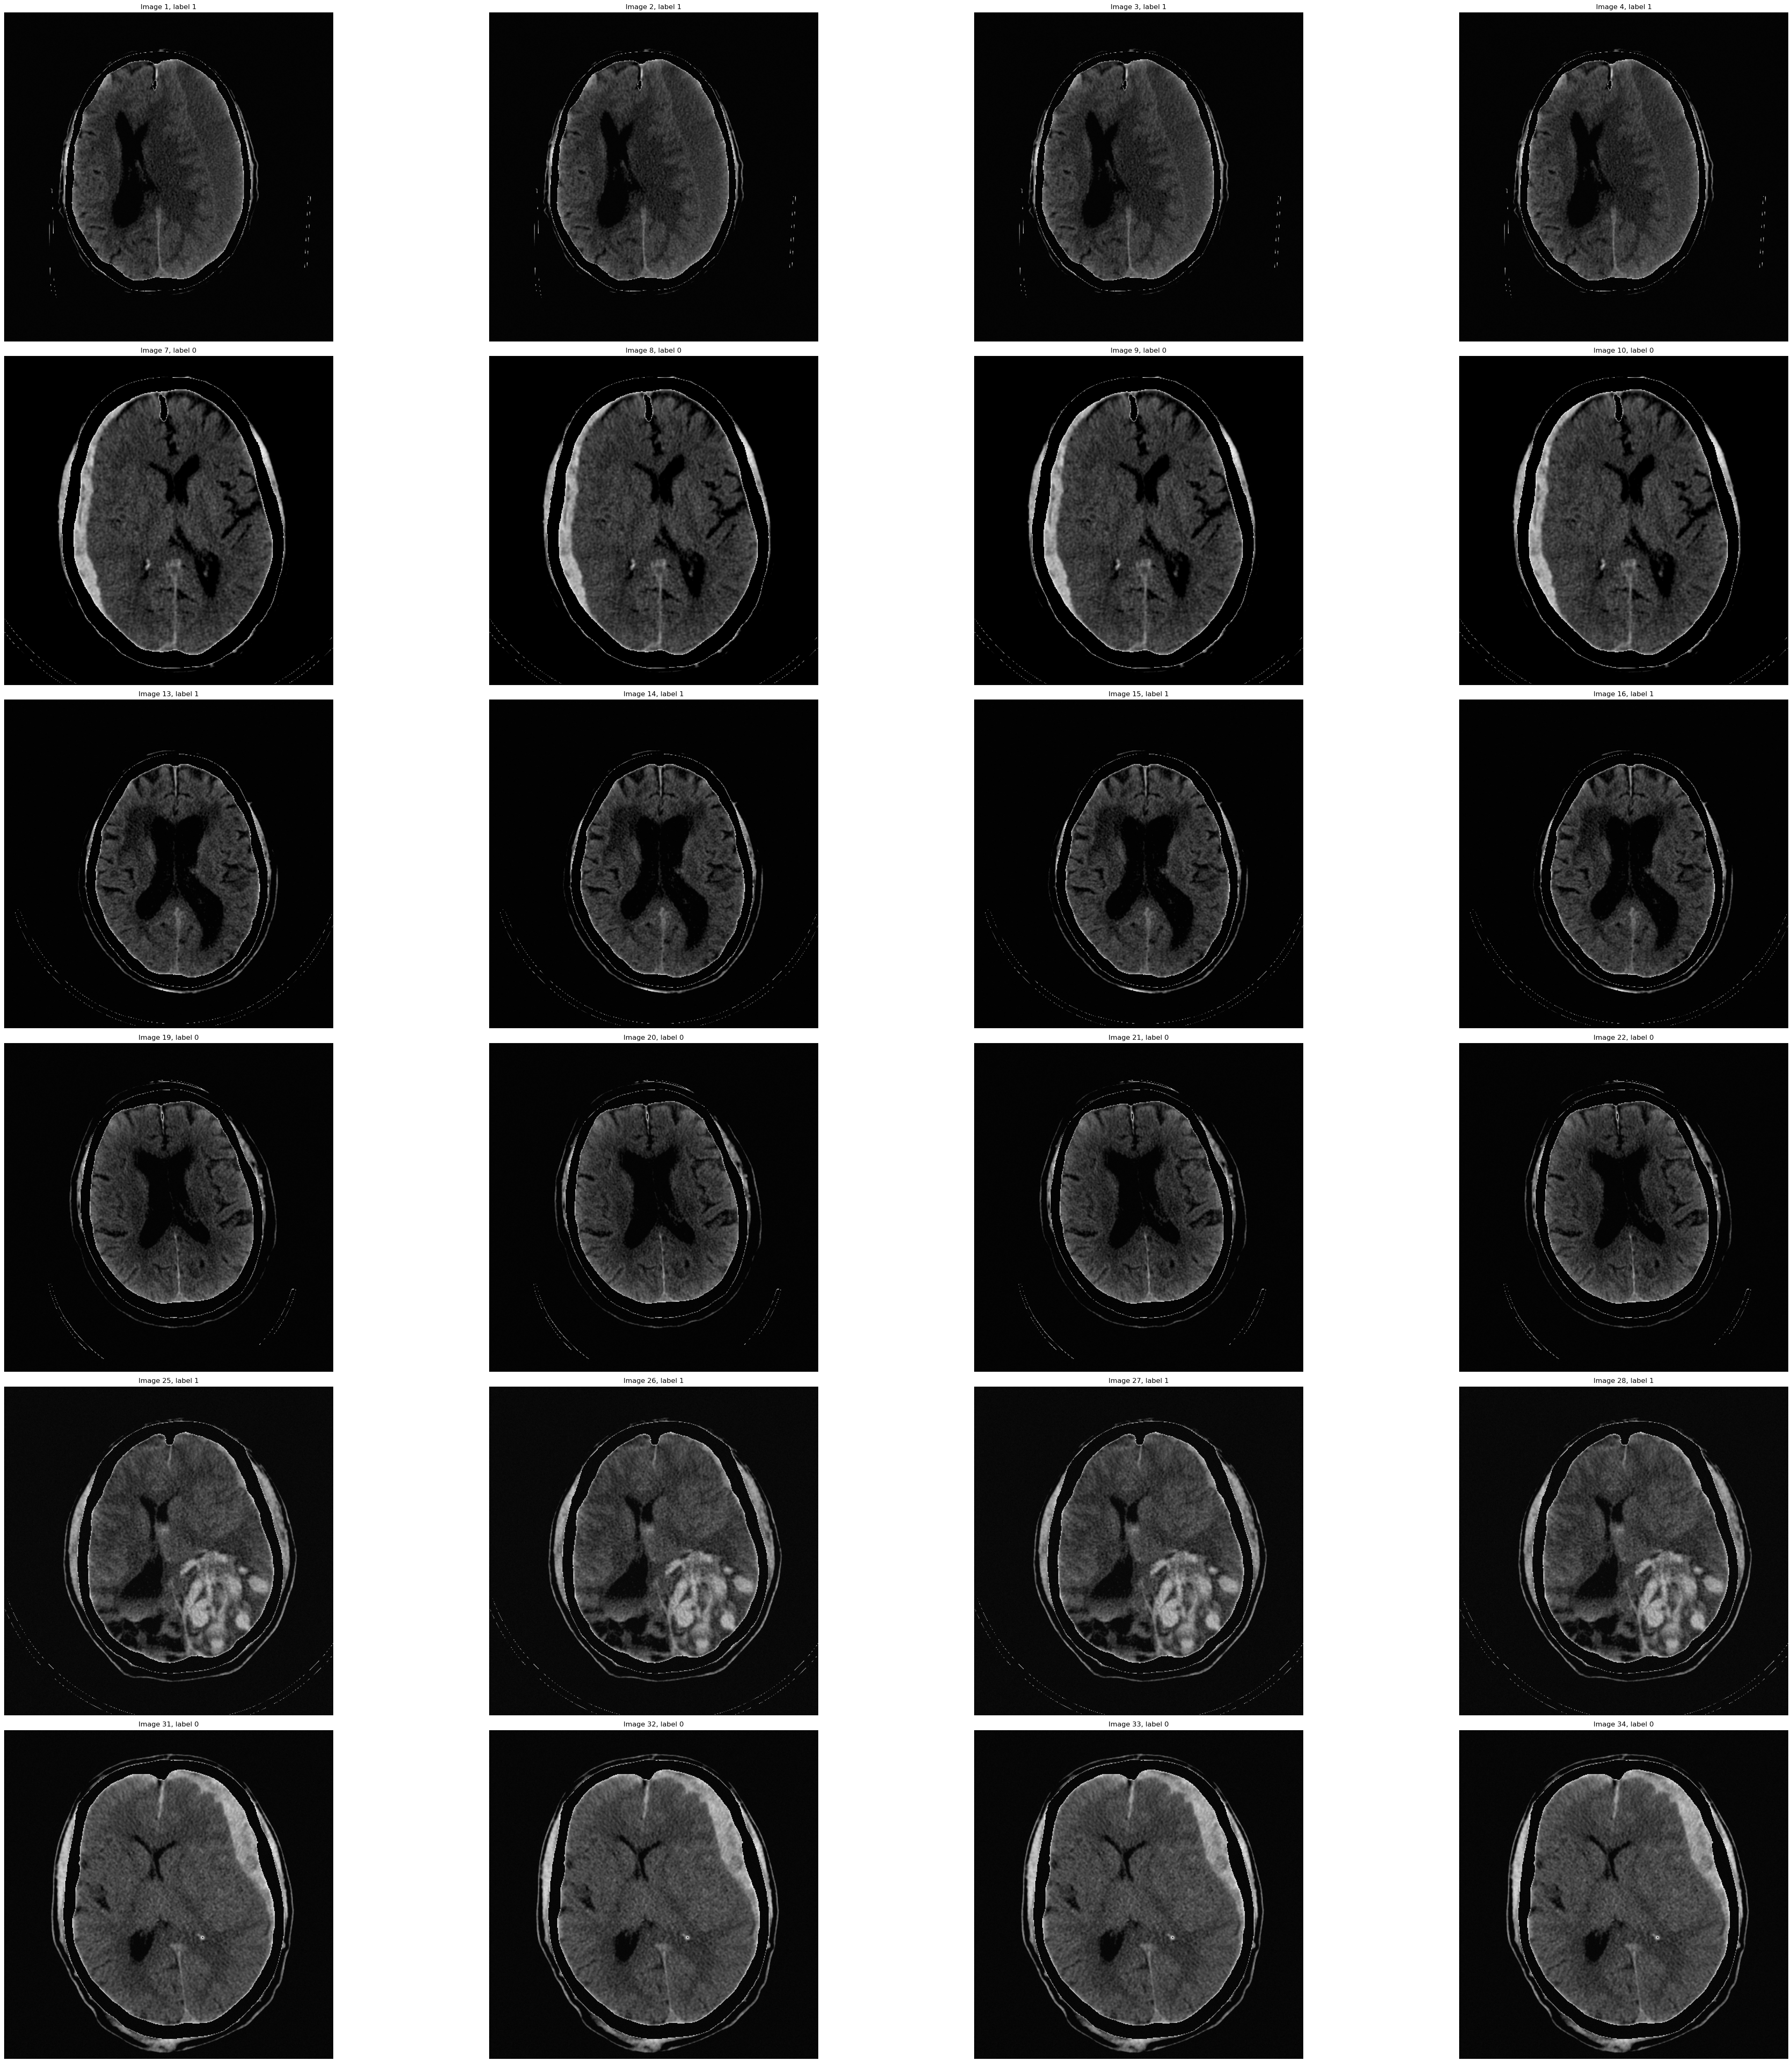

In [16]:
def visualize_images(loader):
    batch_data = next(iter(loader))  # Get one batch from the loader
    images = batch_data['image']
    labels = batch_data['label']

    fig, axs = plt.subplots(6, 4, figsize=(50, 50))

    for i in range(6):  # Iterate through rows
        for j in range(4):  # Iterate through columns
            img = images[i][0].cpu().detach().numpy()
            lab= labels[i].cpu().detach().numpy()
            # plot middle slice of the 3D image
            axs[i, j].imshow(img[(np.rint(img.shape[0]/2)).astype(int), :, :], cmap='gray')
            axs[i, j].set_title(f'Image {i*6 + j + 1}, label {lab}')  # Adjust the title
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.savefig('/home/ubuntu/tenerife/data/ICH_results/DataAugmentationImagesForWilson/imagesDataAugRandGaussianNoise.png')
    plt.show()
    

visualize_images(train_loader)